In [1]:
library(Seurat)
library(dplyr)
library(ggplot2)
library(dendextend)
library(circlize)
library(viridis)
library(tibble)
library(ComplexHeatmap)
library(viridis)
inputdir <- "./load_files/"
outputdir <- "./report/"
source("./hier.fun.R")

Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



---------------------
Welcome to dendextend version 1.13.4
Type citation('dendextend') for how to cite the package.

Type browseVignettes(package = 'dendextend') for the package vignette.
The github page is: https://github.com/talgalili/dendextend/

Suggestions and bug-reports can be submitted at: https://github.com/talgalili/dendextend/issues
Or contact: <tal.galili@gmail.com>

	To suppress this message use:  suppressPackageStartupMessages(library(dendextend))
---------------------



Attaching package: ‘dendextend’


The following object is masked from ‘package:stats’:

    cutree


circlize version 0.4.13
CRAN page: https://cran.r-project.org/package=circlize
Github page: https:

In [2]:
## Set some variables
load(file = paste0("./load_files/Hier-region.subset.avgs.Rdata"))
##avg, ncell_slim 
hvg <- readRDS(file = paste0("./load_files/Hier-region-cluster.hvg.rds"))

lb_cols <- c("#FF420E", "#FFBB00", "#4CB5F5", "#89DA59", "#878787", "#B037C4") %>% 
            setNames(., c("FC", "MSC", "TC", "OC", "Insula", "GE"))
## Update lobe information
lobe_list <- list(FC = c("FR", "OFC", "DFC", "MFC", "VFC"),
                MSC = c("M1C", "MS", "S1C", "IPC", "PCC"),
                TC = c("TP", "A1C", "ITC", "STC"),
                OC = c("OX", "V1C"),
                Insula = c("Insula"), 
                GE = c("GE", "CGE", "MGE", "LGE"))
reg2lb <- lapply(names(lobe_list), function(x) setNames(rep(x, length(lobe_list[[x]])), lobe_list[[x]])) %>%
            unlist()
reg_cols <- setNames(lb_cols[reg2lb], names(reg2lb))

In [3]:
##---------------------------------------------------------------------
## Do dendrograms using E93 data

## Filter clusters based on the number of cells
ag <- "E93"
ncell <- ncell_slim
avg_use <- avg
cls_knots <- lapply(dimnames(ncell)[[1]], function(cls) {
                regs <- names(ncell[cls, ])[ncell[cls, ] >= 40]
                lbs <- unique(reg2lb[regs])
                if (sum(c("FC", "OC") %in% lbs) == 2 & (sum(c("MSC", "TC", "Insula") %in% lbs) >= 1)){
                    cls_reg <- paste0(cls, "|", regs)
                } else {
                    cls_reg <- NULL
                }
                return(cls_reg)
                }) %>%
                setNames(., dimnames(ncell)[[1]])
cls_knots <- cls_knots[!sapply(cls_knots, is.null)]
knots <- unlist(cls_knots, use.names = FALSE)
knot_reg <- strsplit(knots, "|", fixed = TRUE) %>%
                sapply(., function(x) x[2])
knot_cols <- setNames(lb_cols[reg2lb[knot_reg]], knots)

Warning message in branches_attr_by_labels(., labels = c("OFC", "DFC", "MFC", "VFC"), :
“Not all of the labels you provided are included in the dendrogram.
The following labels were omitted:VFC”
Warning message in branches_attr_by_labels(., labels = c("M1C", "S1C", "IPC", "PCC"), :
“Not all of the labels you provided are included in the dendrogram.
The following labels were omitted:S1CIPC”
Warning message in branches_attr_by_labels(., labels = c("A1C", "ITC", "STC"), TF_value = c("#4CB5F5", :
“Not all of the labels you provided are included in the dendrogram.
The following labels were omitted:A1CSTC”
Warning message in branches_attr_by_labels(., labels = c("OFC", "DFC", "MFC", "VFC"), :
“Not all of the labels you provided are included in the dendrogram.
The following labels were omitted:VFC”
Warning message in branches_attr_by_labels(., labels = c("M1C", "S1C", "IPC", "PCC"), :
“Not all of the labels you provided are included in the dendrogram.
The following labels were omitted:S1CIPC”

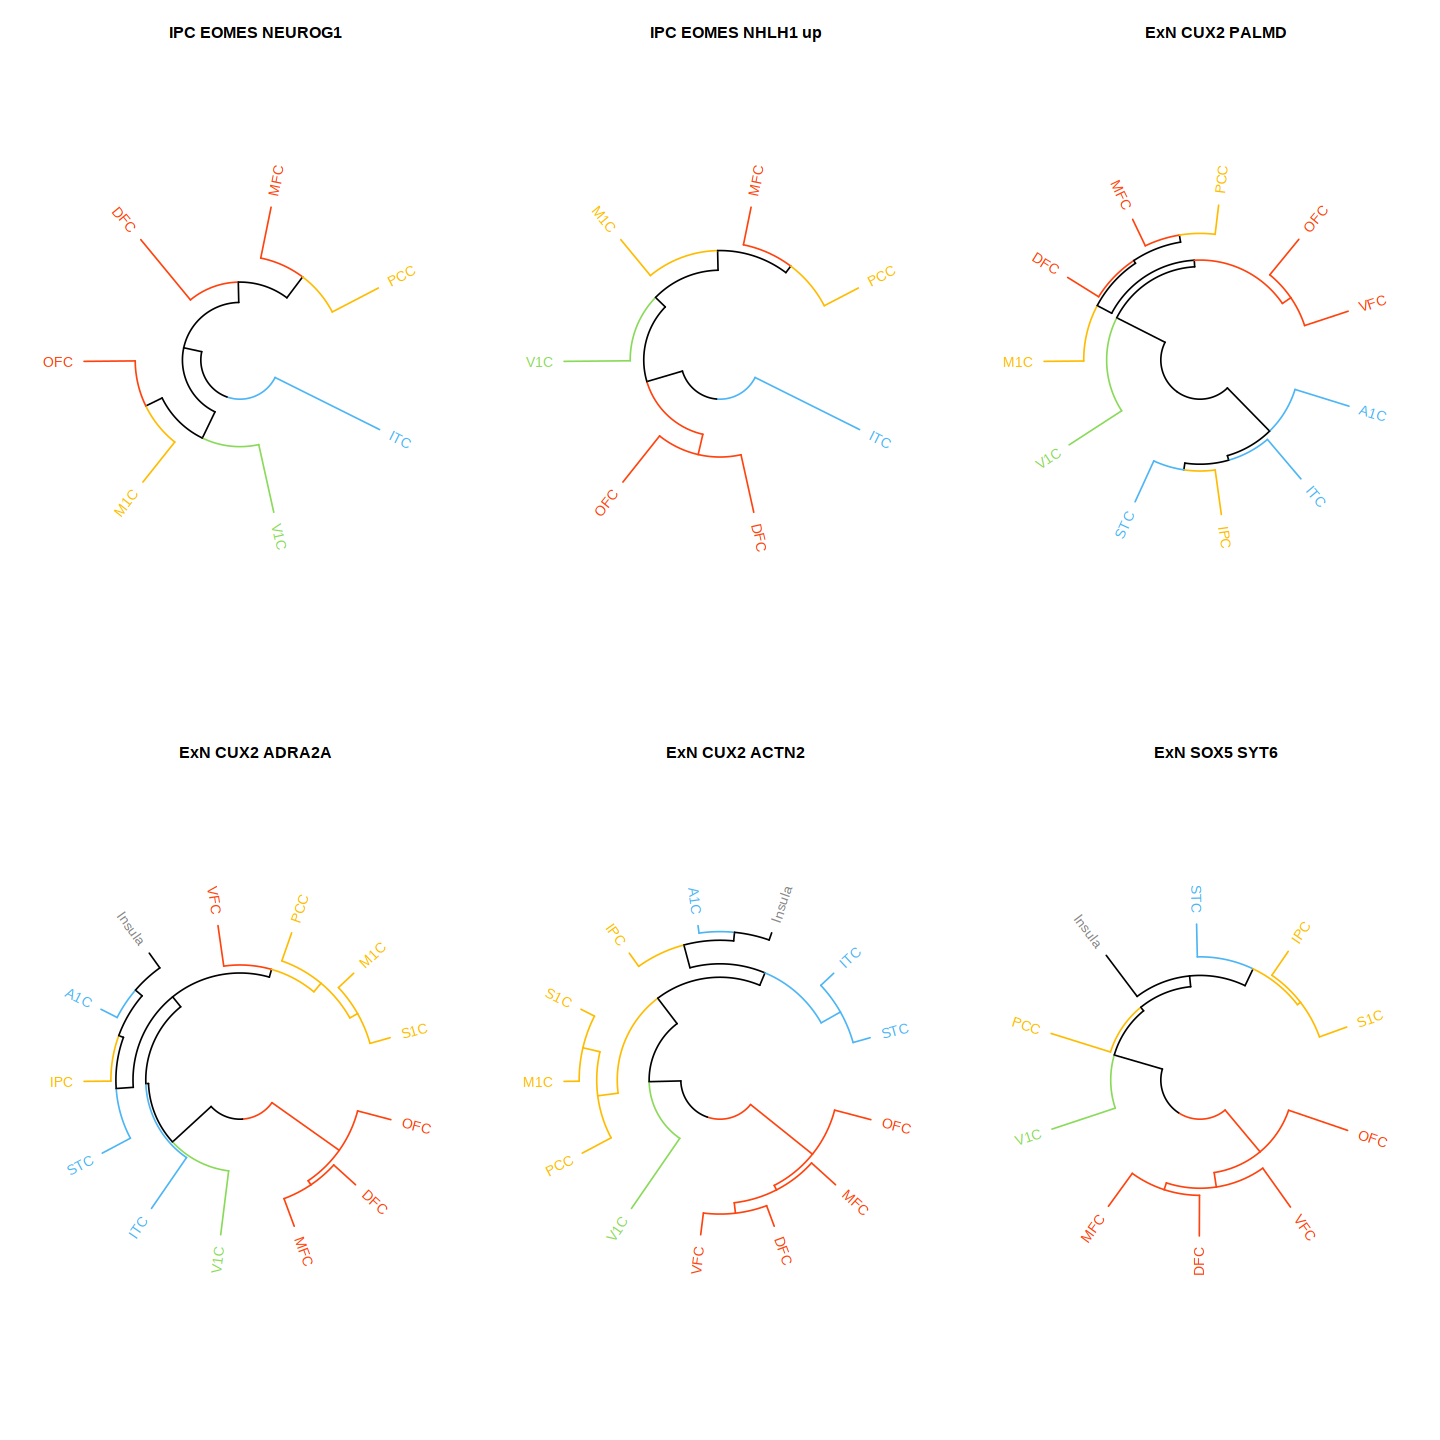

In [4]:
## Plot
cls_ord <- c("IPC EOMES NEUROG1", "IPC EOMES NHLH1 deep", "IPC EOMES NHLH1 up", "ExN SOX5 PALMD", "ExN CUX2 PALMD", 
            "ExN CUX2 ADRA2A", "ExN CUX2 ACTN2",
            "ExN SOX5 NR4A2 GRID2", "ExN SOX5 SYT6", "ExN SOX5 OPRK1 NR4A2", "ExN SOX5 OPRK1 SULF1")
avg <- avg_use[hvg, knots]
##pdf(paste0("./report/Circle_Dendro_", ag, ".pdf"), width = 12, height = 12)
options(repr.plot.width=12, repr.plot.height=12, res = 300)
layout(matrix(1:6, nrow = 2, ncol = 3, byrow = TRUE))
for (ii in intersect(cls_ord, names(cls_knots))) {
    sub_knots <- grep(ii, knots, value = TRUE)
    plot_circlize_dendrogram(data = avg[, sub_knots], dist.method = c("cor", "dist")[1])
    title(paste0(ii)) 
    circos.clear()
}
##dev.off()

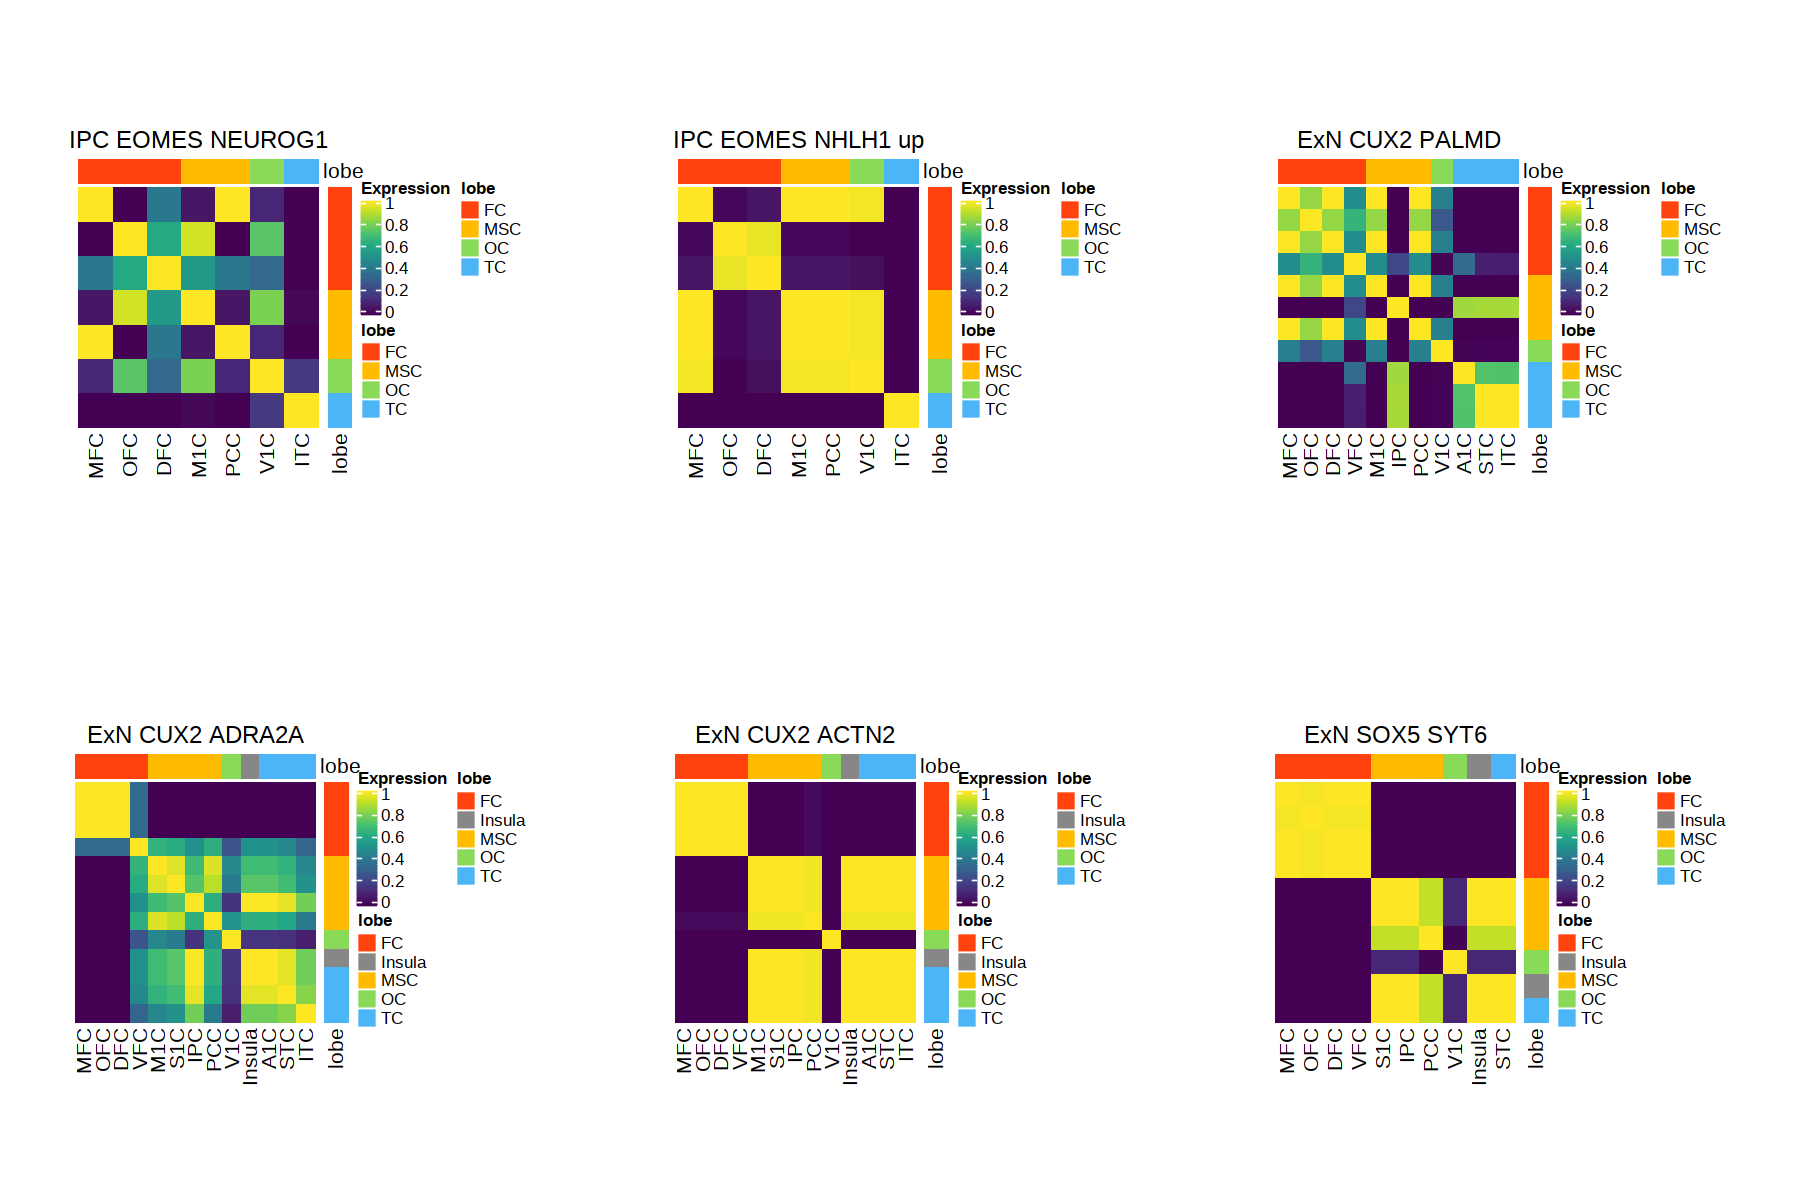

In [5]:
## Use bootstrap to evaluate the co-clustering frequency among regions
reg_ord <- c("MFC", "OFC", "DFC", "VFC", "M1C", "S1C", "IPC", "PCC", "V1C", "Insula", "A1C", "STC", "ITC")
set.seed(42)
hvg_list <- replicate(1000, sample(hvg, ceiling(length(hvg) * 0.8)), simplify = FALSE)


options(repr.plot.width=15, repr.plot.height=10, res = 300)

knots_plot <- intersect(cls_ord, names(cls_knots))
pushViewport(viewport(layout = grid.layout(nr = 2, nc = 3)))
for (ii in 1:length(knots_plot)) {
    ##print(ii)
    sub_knots <- grep(knots_plot[ii], knots, value = TRUE)
    simi_mat <- Bootstrap_cocluster(data = avg_use[, sub_knots], 
                                    hvg.list = hvg_list, dist.method = c("cor", "dist")[1], reg_ord = reg_ord) 

    ##pdf(paste0("./report/HC-region_cocluster_freq_E93_", ii, ".pdf"), width = 4, height = 4)
    pushViewport(viewport(layout.pos.row = ceiling(ii/3), layout.pos.col = ii - (ceiling(ii/3) - 1) * 3))
    htt <- Plot_Cocluster_Heatmap(mat = simi_mat, reg_ord = reg_ord, rm_na = TRUE, title = knots_plot[[ii]])
    draw(htt, newpage =FALSE)
    popViewport()
    ##dev.off()
}


In [6]:
pdf(paste0("./report/HC-region_cocluster_freq_E93.pdf"), width = 4 * 3, height = 4 * 2)
pushViewport(viewport(layout = grid.layout(nr = 2, nc = 3)))
for (ii in 1:length(knots_plot)) {
    sub_knots <- grep(knots_plot[ii], knots, value = TRUE)
    simi_mat <- Bootstrap_cocluster(data = avg_use[, sub_knots], 
                                    hvg.list = hvg_list, dist.method = c("cor", "dist")[1], reg_ord = reg_ord) 

    pushViewport(viewport(layout.pos.row = ceiling(ii/3), layout.pos.col = ii - (ceiling(ii/3) - 1) * 3))
    htt <- Plot_Cocluster_Heatmap(mat = simi_mat, reg_ord = reg_ord, rm_na = TRUE, title = knots_plot[[ii]])
    draw(htt, newpage =FALSE)
    popViewport()
}
dev.off()

png 
  2

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6


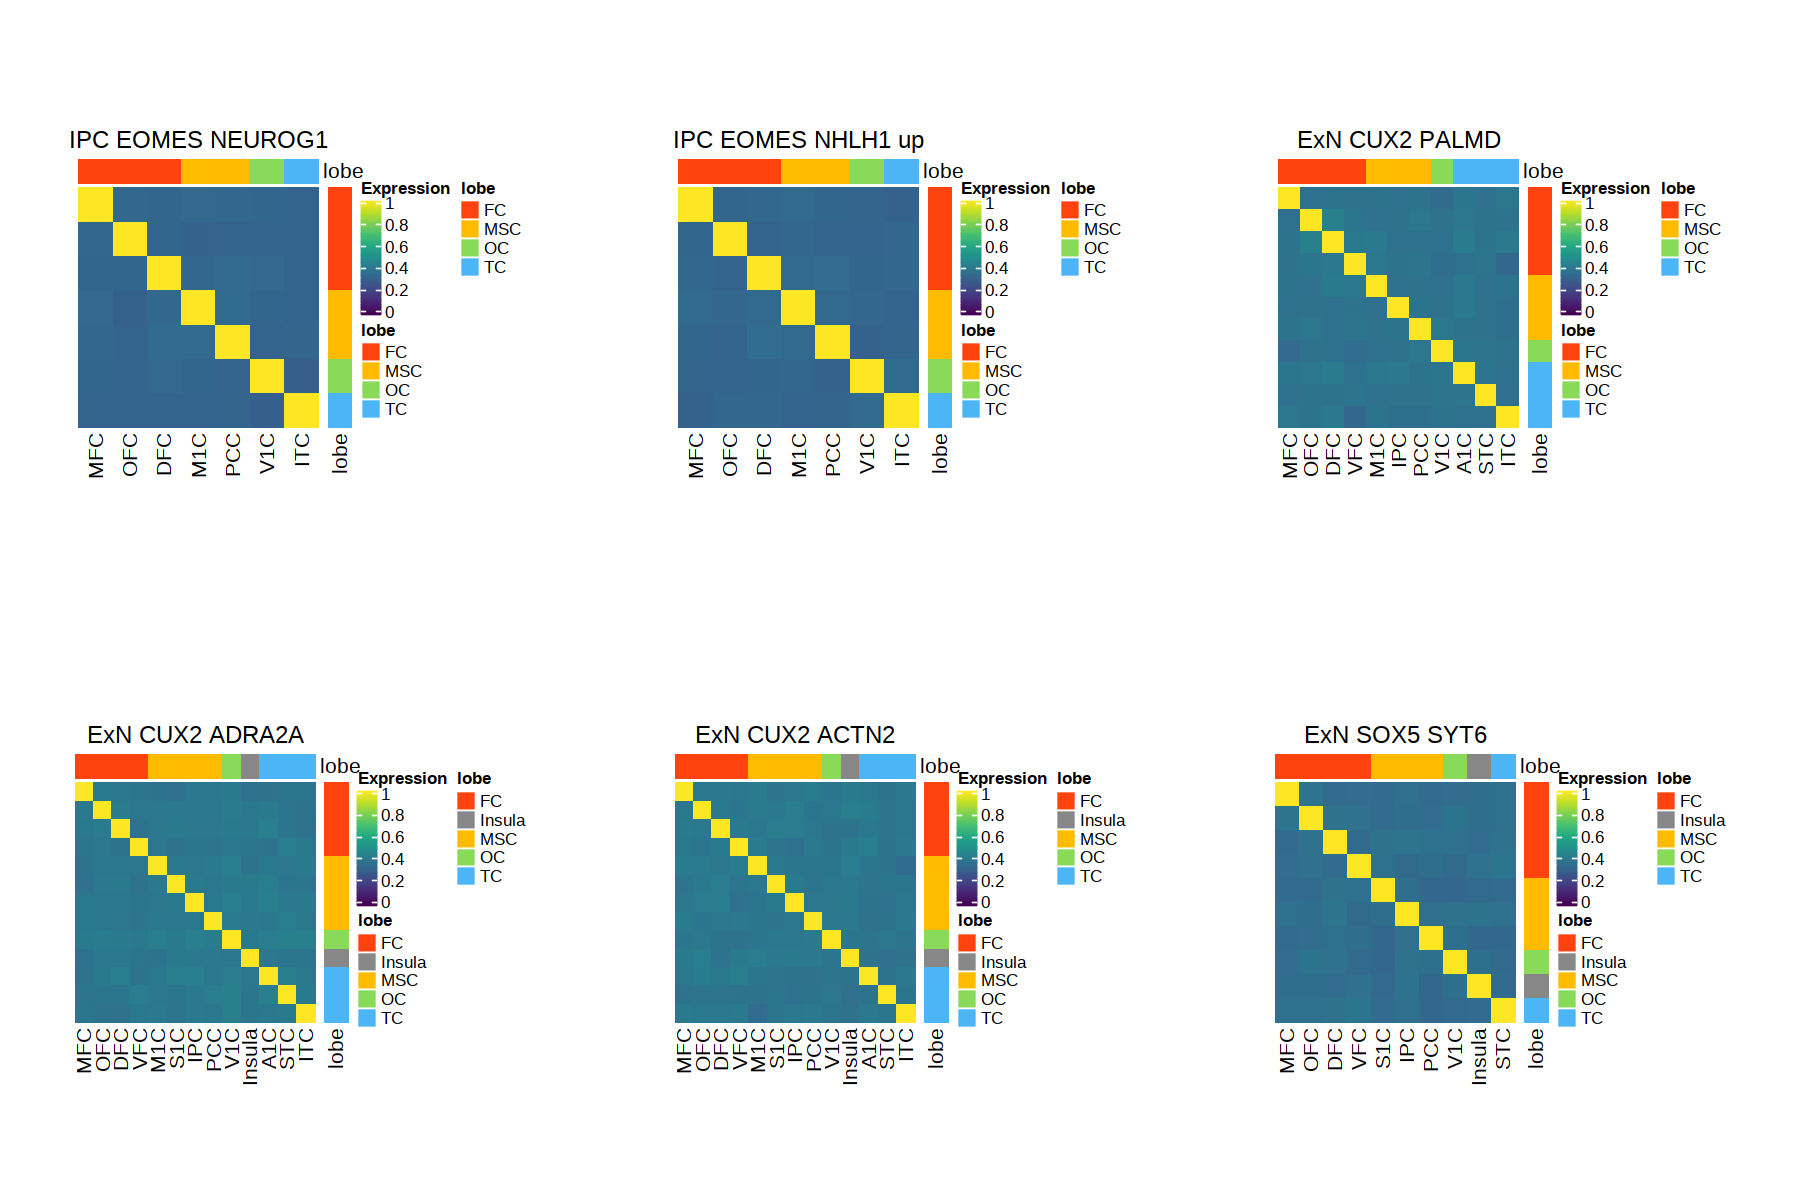

In [7]:
perm_res <- readRDS(file = paste0("./load_files/Hier-region.perm.avgs.rds"))

options(repr.plot.width=15, repr.plot.height=10, res = 300)
pushViewport(viewport(layout = grid.layout(nr = 2, nc = 3)))

for (ii in 1:length(knots_plot)) {
    print(ii)
    sub_knots <- grep(knots_plot[ii], knots, value = TRUE)
    avg_list <- lapply(perm_res, function(avggg) {
        return(avggg[, sub_knots])
    })

    simi_mat <- Permutate_cocluster(data.list = avg_list, dist.method = "cor", reg_ord = reg_ord)

    ##pdf(paste0("./report/HC-region_cocluster_freq_perm_E93_", ii, ".pdf"), width = 4, height = 4)
    pushViewport(viewport(layout.pos.row = ceiling(ii/3), layout.pos.col = ii - (ceiling(ii/3) - 1) * 3))
    htt <- Plot_Cocluster_Heatmap(mat = simi_mat, reg_ord = reg_ord, rm_na = TRUE, title = knots_plot[[ii]])
    draw(htt, newpage =FALSE)
    popViewport()
    ##dev.off()
}



In [8]:
pdf(paste0("./report/HC-region_cocluster_freq_perm_E93.pdf"), width = 4 * 3, height = 4 * 2)
pushViewport(viewport(layout = grid.layout(nr = 2, nc = 3)))
for (ii in 1:length(knots_plot)) {
    print(ii)
    sub_knots <- grep(knots_plot[ii], knots, value = TRUE)
    avg_list <- lapply(perm_res, function(avggg) {
        return(avggg[, sub_knots])
    })

    simi_mat <- Permutate_cocluster(data.list = avg_list, dist.method = "cor", reg_ord = reg_ord)

    pushViewport(viewport(layout.pos.row = ceiling(ii/3), layout.pos.col = ii - (ceiling(ii/3) - 1) * 3))
    htt <- Plot_Cocluster_Heatmap(mat = simi_mat, reg_ord = reg_ord, rm_na = TRUE, title = knots_plot[[ii]])
    draw(htt, newpage =FALSE)
    popViewport()
    
}
dev.off()

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6


png 
  2

In [9]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server 7.9 (Maipo)

Matrix products: default
BLAS/LAPACK: /gpfs/gibbs/pi/sestan.ycga/sm2726/Tools/Anaconda3/lib/libopenblasp-r0.3.7.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] ComplexHeatmap_2.2.0 tibble_3.0.1         viridis_0.5.1       
[4] viridisLite_0.3.0    circlize_0.4.13      dendextend_1.13.4   
[7] ggplot2_3.3.0        dplyr_1.0.7          Seurat_3.1.5        

loaded via a namespace (and not attached):
 [